Inspired from Valentin Emiya's notebook

In [ ]:
# Autoreload modifications from imported modules
%load_ext autoreload
%autoreload 2
# Plot figures in the notebook
%matplotlib inline

In [16]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import bandits
from bandit_problem.bandits.normal_multi_armed_bandits import NormalMultiArmedBandits
from bandit_problem.bandits.bernouilli_multi_armed_bandits import BernoulliMultiArmedBandits

# Import bandit algorithms
from bandit_problem.algorithm.random_bandit_algorithm import RandomBanditAlgorithm
from bandit_problem.algorithm.epsilon_greedy_bandit_algorithm import EpsilonGreedyBanditAlgorithm
from bandit_problem.algorithm.ucb_bandit_algorithm import UcbBanditAlgorithm
from bandit_problem.algorithm.thompson_sampling_algorithm import ThompsonSamplingAlgorithm

import numpy as np

# Import and configure matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 10
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.markersize'] = 15

In [17]:
bandits = NormalMultiArmedBandits(n_arms=4)
print(bandits)

# Draws several times each arm and compare the mean profit with the unknown expected values
n_draws = 100
for i_arm in range(bandits.n_arms):
    x = 0
    for i_draw in range(n_draws):
        x += bandits.step(i_arm)
    print('Mean profit of the arm {} on {} drawings: {:.3f} (expected value of the arm: {:.3f})'
          .format(i_arm, n_draws, x/n_draws, bandits._true_values[i_arm]))

4-arms bandit with Normal distributions
Mean profit of the arm 0 on 100 drawings: 0.554 (expected value of the arm: 0.492)
Mean profit of the arm 1 on 100 drawings: 0.089 (expected value of the arm: 0.194)
Mean profit of the arm 2 on 100 drawings: -0.778 (expected value of the arm: -0.616)
Mean profit of the arm 3 on 100 drawings: 3.695 (expected value of the arm: 3.855)


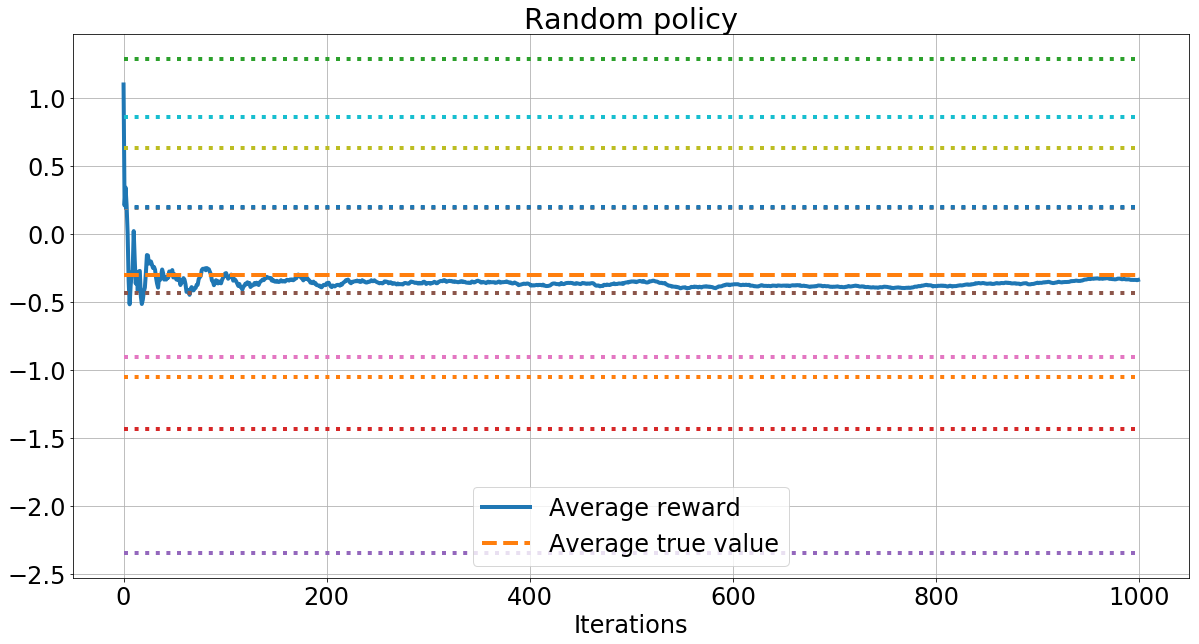

In [18]:
n_iterations = 1000

bandits = NormalMultiArmedBandits(n_arms=10)
r = np.zeros(n_iterations)
algo = RandomBanditAlgorithm(n_arms=bandits.n_arms)
for i_iteration in range(n_iterations):
    a = algo.get_action() # Get an action
    r[i_iteration] = bandits.step(a) # Get the reward
    algo.fit_step(action=a, reward=r[i_iteration]) # Reassessment (no effect here)

plt.plot(np.cumsum(r[:]) / np.arange(1, n_iterations+1), label='Average reward')
plt.plot([0, n_iterations-1], [np.mean(bandits._true_values)] * 2, '--', label='Average true value')
for i_arm in range(bandits.n_arms):
    plt.plot([0, n_iterations-1], [bandits._true_values[i_arm]] * 2, ':')
plt.xlabel('Iterations')
plt.legend()
plt.title('Random policy')
plt.grid()

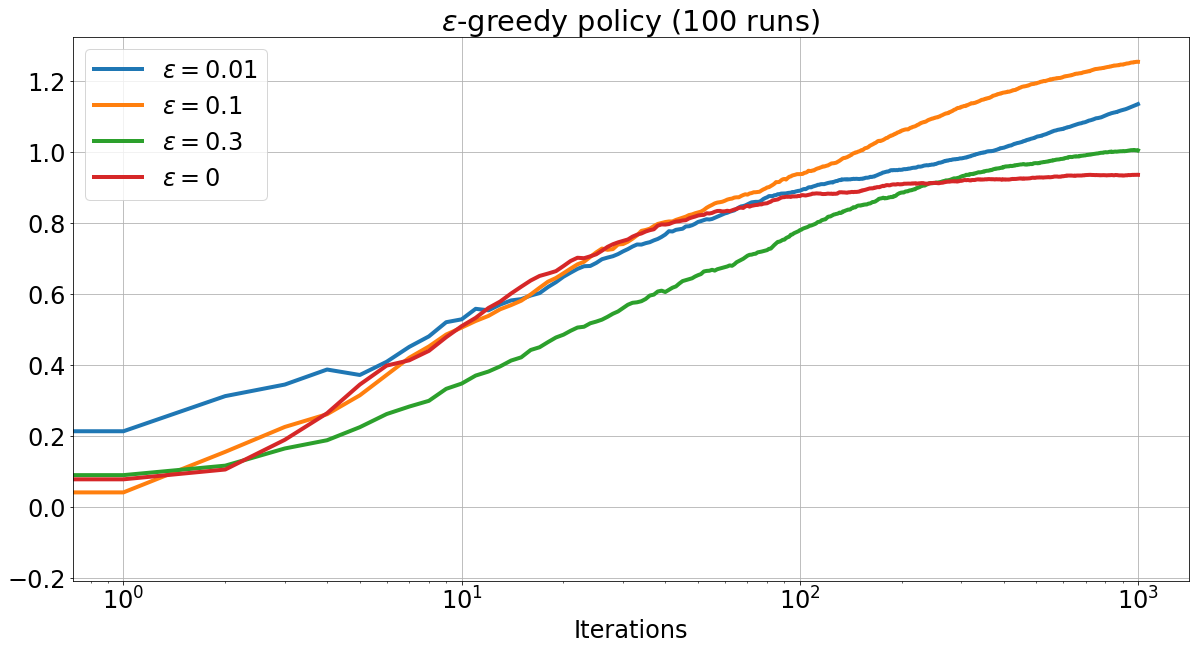

In [19]:
n_iterations = 1000
n_runs = 100
epsilon_list = [0.01, 0.1, 0.3, 0]

r_cum = np.zeros((n_iterations, len(epsilon_list)))
for i_run in range(n_runs):
    bandits = NormalMultiArmedBandits(n_arms=10)
    for i_eps, epsilon in enumerate(epsilon_list):
        eps_greedy = EpsilonGreedyBanditAlgorithm(n_arms=bandits.n_arms, epsilon=epsilon)
        for i_iteration in range(n_iterations):
            a = eps_greedy.get_action() # Get an action
            r = bandits.step(a) # Get the reward
            r_cum[i_iteration, i_eps] += r
            eps_greedy.fit_step(action=a, reward=r) # Reassessment
for i_eps, epsilon in enumerate(epsilon_list):
    plt.plot(np.cumsum(r_cum[:, i_eps]) / np.arange(1, n_iterations+1) / n_runs, label='$\epsilon={}$'.format(epsilon))
plt.xlabel('Iterations')
plt.legend()
plt.title('$\epsilon$-greedy policy ({} runs)'.format(n_runs))
plt.xscale('log')
plt.grid()

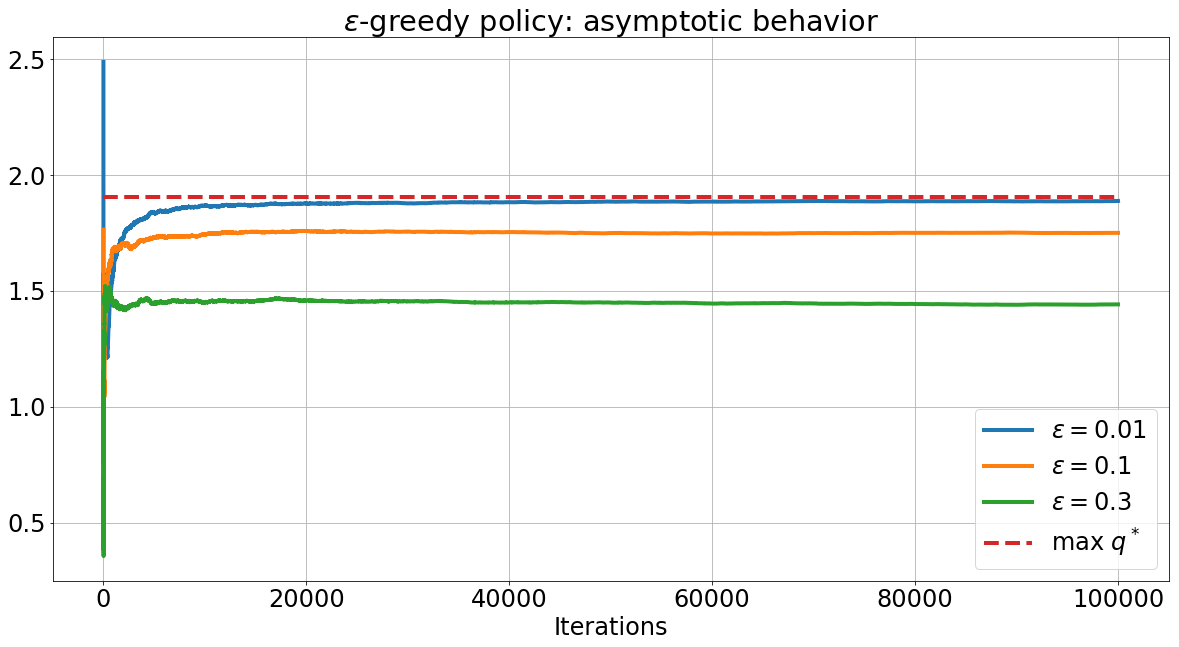

In [20]:
n_iterations = 100000
n_runs = 1
epsilon_list = [0.01, 0.1, 0.3]

r_cum = np.zeros((n_iterations, len(epsilon_list)))
for i_run in range(n_runs):
    bandits = NormalMultiArmedBandits(n_arms=10)
    for i_eps, epsilon in enumerate(epsilon_list):
        eps_greedy = EpsilonGreedyBanditAlgorithm(n_arms=bandits.n_arms, epsilon=epsilon)
        for i_iteration in range(n_iterations):
            a = eps_greedy.get_action() # Choose an action
            r = bandits.step(a) # Get the reward
            r_cum[i_iteration, i_eps] += r
            eps_greedy.fit_step(action=a, reward=r) # Reassessment
for i_eps, epsilon in enumerate(epsilon_list):
    plt.plot(np.cumsum(r_cum[:, i_eps]) / np.arange(1, n_iterations+1) / n_runs, label='$\epsilon={}$'.format(epsilon))
plt.plot([0, n_iterations-1], [np.max(bandits._true_values)] * 2, '--', label='max $q^*$')
plt.xlabel('Iterations')
plt.legend()
plt.title('$\epsilon$-greedy policy: asymptotic behavior')
plt.grid()

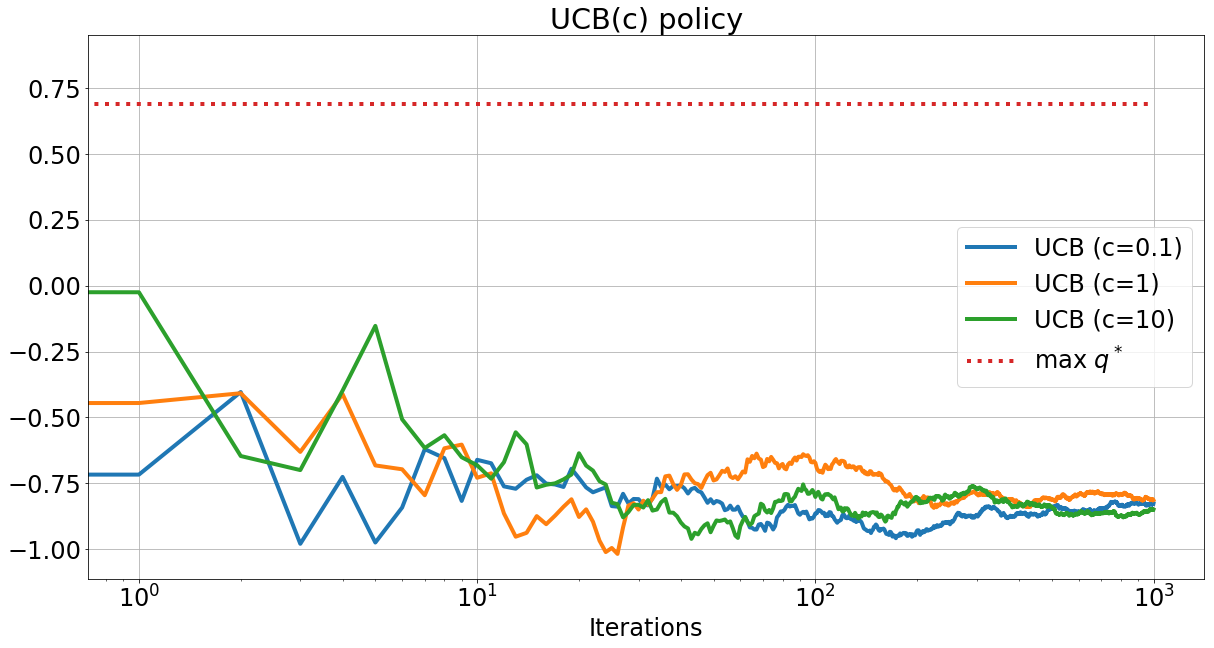

In [21]:
n_iterations = 1000
bandits = NormalMultiArmedBandits(n_arms=10)
c_list = [0.1, 1, 10]
for c in c_list:
    algo = UcbBanditAlgorithm(n_arms=bandits.n_arms, c=c)
    r = np.zeros(n_iterations)
    for i_iteration in range(n_iterations):
        a = algo.get_action() # Choose an action
        r[i_iteration] = bandits.step(a) # Get the reward
        algo.fit_step(action=a, reward=r[i_iteration]) # Reassessment (no effect here)
    plt.plot(np.cumsum(r[:]) / np.arange(1, n_iterations+1), label='UCB (c={})'.format(c))
    
plt.plot([0, n_iterations-1], [np.max(bandits._true_values)] * 2, ':', label='max $q^*$')
plt.xlabel('Iterations')
plt.legend()
plt.title('UCB(c) policy')
plt.xscale('log')
plt.grid()

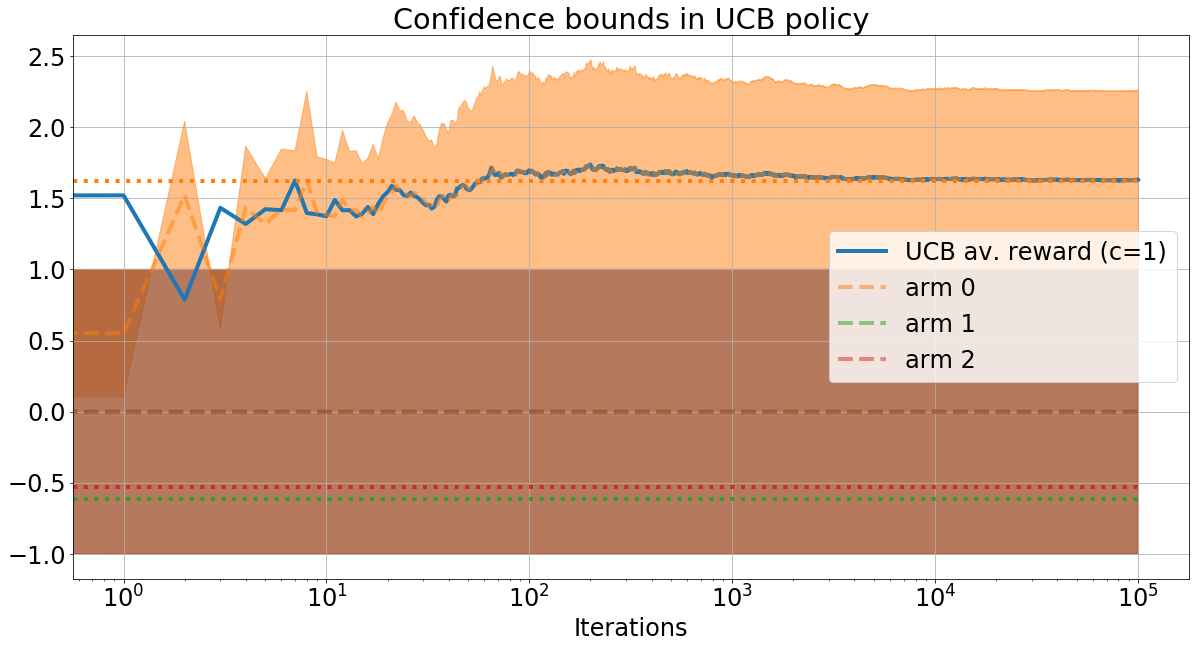

In [22]:
# Display bounds

np.random.seed(1)
n_iterations = 100000
c = 1
bandits = NormalMultiArmedBandits(n_arms=3)
algo = UcbBanditAlgorithm(n_arms=bandits.n_arms, c=c)
r = np.zeros(n_iterations)
ucb = np.zeros((n_iterations, bandits.n_arms))
value_estimates = np.zeros((n_iterations, bandits.n_arms))
for i_iteration in range(n_iterations):
    a = algo.get_action() # Choose an action
    ucb[i_iteration, :] = algo.get_upper_confidence_bound()
    value_estimates[i_iteration, :] = algo._value_estimates
    r[i_iteration] = bandits.step(a) # Get the reward
    algo.fit_step(action=a, reward=r[i_iteration]) # Reassessment (no effect here)
lcb = 2 * value_estimates - ucb
plt.plot(np.cumsum(r[:]) / np.arange(1, n_iterations+1), label='UCB av. reward (c={})'.format(c))
    
for i_arm in range(bandits.n_arms):
    x = plt.plot([0, n_iterations-1], [bandits._true_values[i_arm]] * 2, ':')
    plt.plot(value_estimates[:, i_arm], '--', alpha=0.5, color=x[0].get_color(), label='arm {}'.format(i_arm))
    plt.fill_between(np.arange(n_iterations), lcb[:, i_arm], ucb[:, i_arm], alpha=0.5, color=x[0].get_color())
plt.xlabel('Iterations')
plt.legend()
plt.title('Confidence bounds in UCB policy')
plt.xscale('log')
plt.grid()


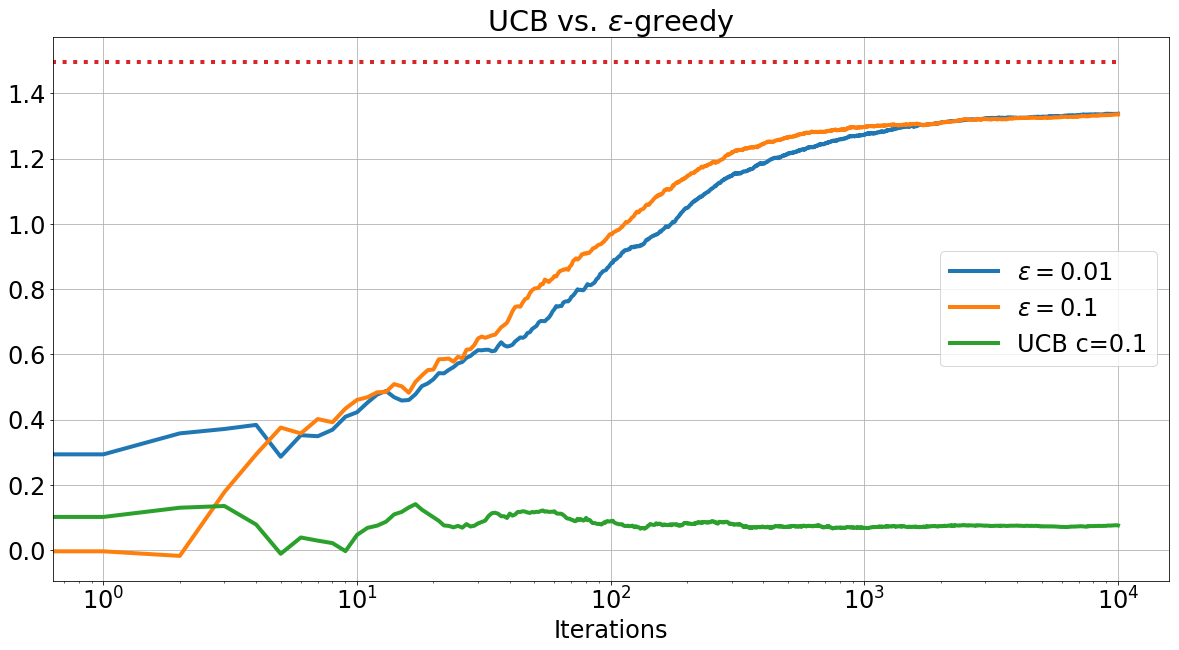

In [23]:
n_iterations = 10000
n_runs = 20
n_arms = 10
epsilon_list = [0.01, 0.1]
algorithms = dict()
for epsilon in epsilon_list:
    algorithms['$\epsilon={}$'.format(epsilon)] = \
        lambda : EpsilonGreedyBanditAlgorithm(n_arms=n_arms, epsilon=epsilon)
c = 0.1
algorithms['UCB c={}'.format(c)] = lambda : UcbBanditAlgorithm(n_arms=n_arms, c=c)

n_algorithms = len(algorithms)
r_cum = dict()
for k_algo in algorithms.keys():
    r_cum[k_algo] = np.zeros((n_iterations))
max_q = 0
for i_run in range(n_runs):
    bandits = NormalMultiArmedBandits(n_arms=n_arms)
    max_q += np.max(bandits._true_values)
    for k_algo, algo in algorithms.items():
        algo = algo()
        for i_iteration in range(n_iterations):
            a = algo.get_action() # Choose an action
            r = bandits.step(a) # Get the reward
            r_cum[k_algo][i_iteration] += r
            algo.fit_step(action=a, reward=r) # Reassessment (no effect here)
for k_algo, algo in algorithms.items():
    plt.plot(np.cumsum(r_cum[k_algo][:]) / np.arange(1, n_iterations+1) / n_runs, label=k_algo)
plt.plot([0, n_iterations-1], [max_q / n_runs] * 2, ':')
plt.xlabel('Iterations')
plt.legend()
plt.title('UCB vs. $\epsilon$-greedy')
plt.xscale('log')
plt.grid()
    

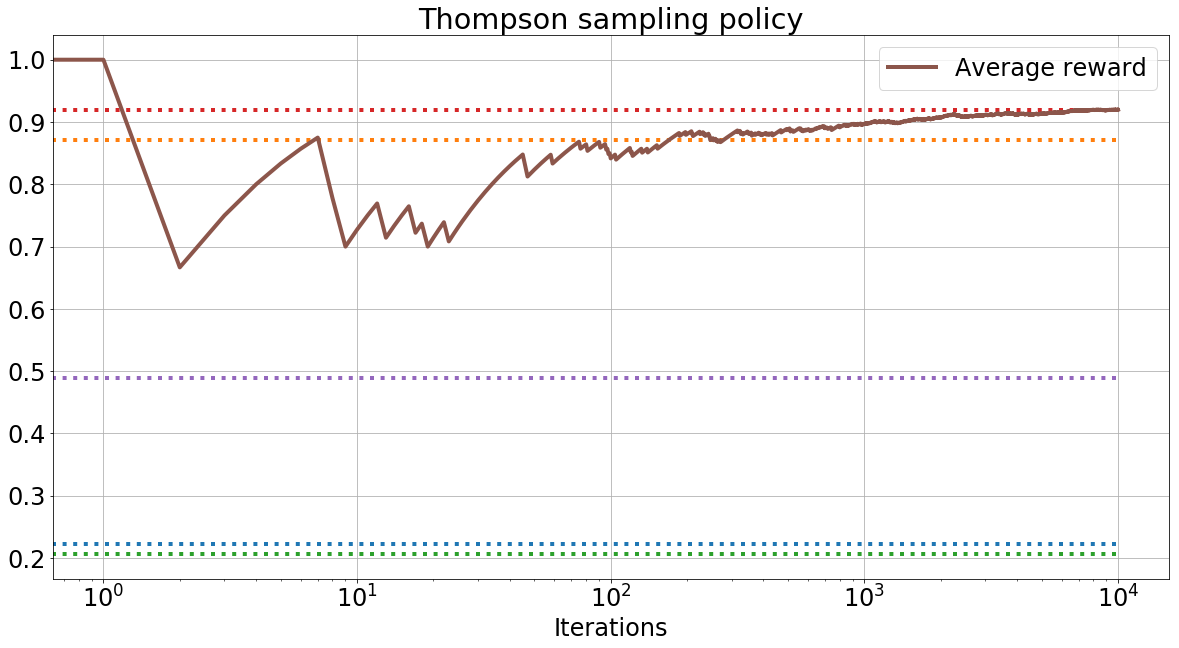

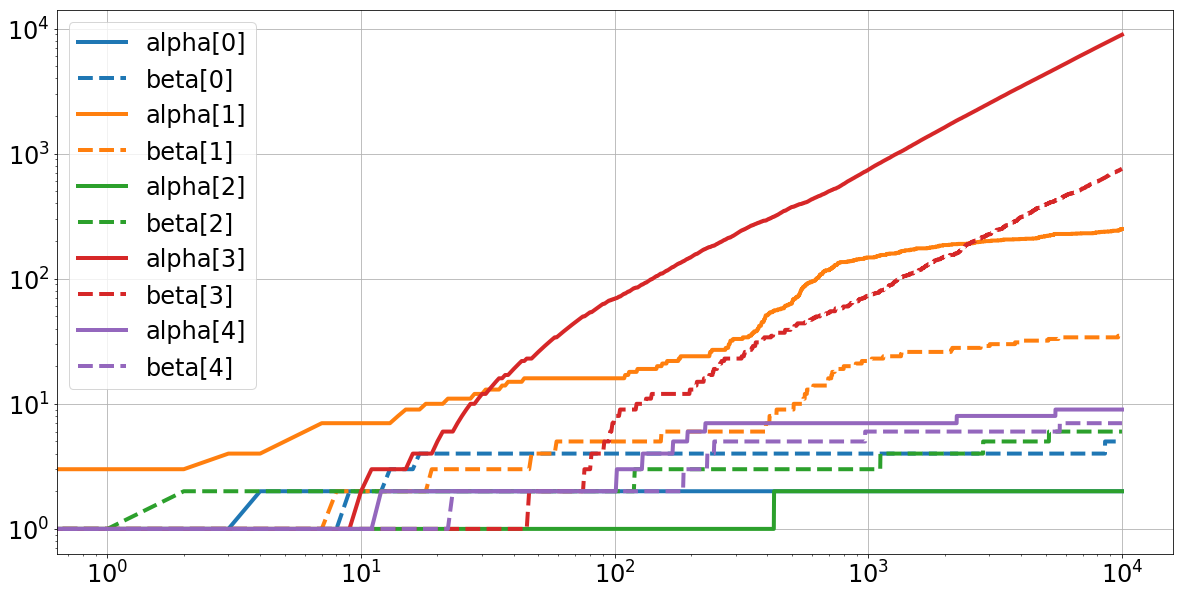

In [24]:
np.random.seed(5)

n_arms = 5
n_iterations = 10000

bandits = BernoulliMultiArmedBandits(np.random.rand(n_arms))
r = np.zeros(n_iterations)
algo = ThompsonSamplingAlgorithm(n_arms=bandits.n_arms)
alphas = np.zeros((n_iterations, n_arms))
betas = np.zeros((n_iterations, n_arms))
for i_iteration in range(n_iterations):
    a = algo.get_action() # Choose an action
    r[i_iteration] = bandits.step(a) # Get the reward
    algo.fit_step(action=a, reward=r[i_iteration]) # Reassessment (no effect here)
    alphas[i_iteration, :] = algo.alpha
    betas[i_iteration, :] = algo.beta

for i_arm in range(bandits.n_arms):
    plt.plot([0, n_iterations-1], [bandits._true_values[i_arm]] * 2, ':')
plt.plot(np.cumsum(r[:]) / np.arange(1, n_iterations+1), label='Average reward')
plt.xlabel('Iterations')
plt.legend()
plt.title('Thompson sampling policy')
plt.grid()
plt.xscale('log')

plt.figure()
for i_arm in range(n_arms):
    x = plt.plot(alphas[:, i_arm], label='alpha[{}]'.format(i_arm))
    plt.semilogy(betas[:, i_arm], '--', label='beta[{}]'.format(i_arm), color=x[0].get_color())
plt.xscale('log')
plt.legend()
plt.grid()
    

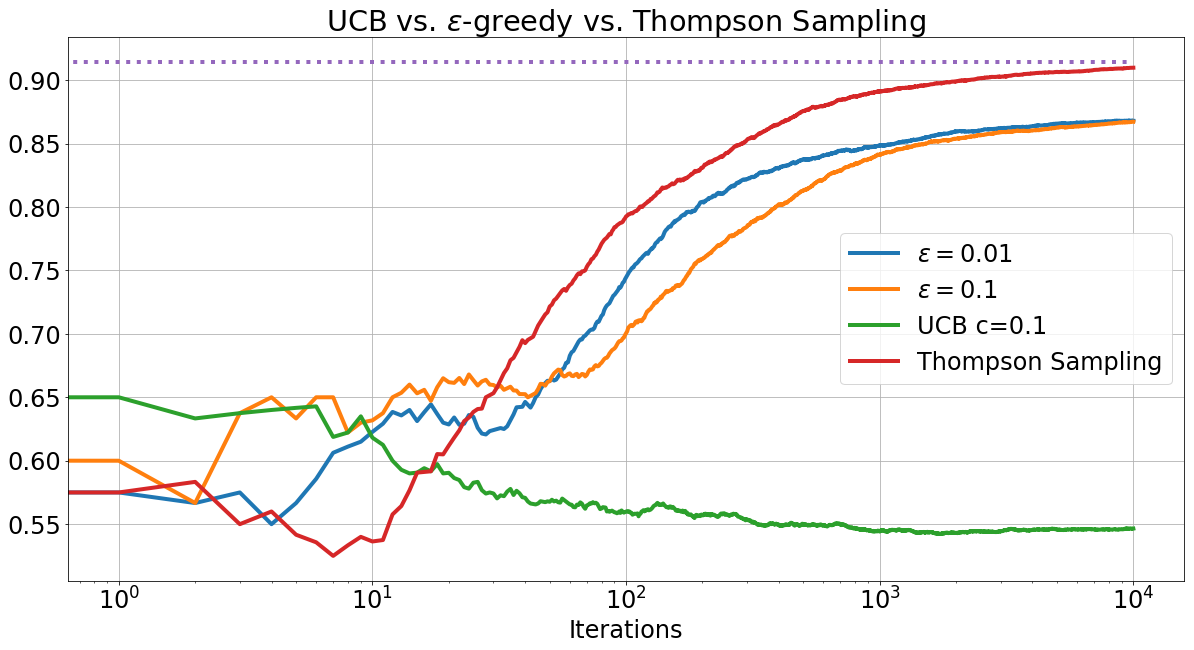

In [25]:
n_iterations = 10000
n_runs = 20
n_arms = 10
epsilon_list = [0.01, 0.1]
algorithms = dict()
for epsilon in epsilon_list:
    algorithms['$\epsilon={}$'.format(epsilon)] = \
        lambda : EpsilonGreedyBanditAlgorithm(n_arms=n_arms, epsilon=epsilon)
c = 0.1
algorithms['UCB c={}'.format(c)] = lambda : UcbBanditAlgorithm(n_arms=n_arms, c=c)
algorithms['Thompson Sampling'] = lambda : ThompsonSamplingAlgorithm(n_arms=n_arms)

n_algorithms = len(algorithms)
r_cum = dict()
for k_algo in algorithms.keys():
    r_cum[k_algo] = np.zeros((n_iterations))
max_q = 0
for i_run in range(n_runs):
    bandits = BernoulliMultiArmedBandits(np.random.rand(n_arms))
    max_q += np.max(bandits._true_values)
    for k_algo, algo in algorithms.items():
        algo = algo()
        for i_iteration in range(n_iterations):
            a = algo.get_action() # Choose an action
            r = bandits.step(a) # Get the reward
            r_cum[k_algo][i_iteration] += r
            algo.fit_step(action=a, reward=r) # Reassessment (no effect here)
for k_algo, algo in algorithms.items():
    plt.plot(np.cumsum(r_cum[k_algo][:]) / np.arange(1, n_iterations+1) / n_runs, label=k_algo)
plt.plot([0, n_iterations-1], [max_q / n_runs] * 2, ':')
plt.xlabel('Iterations')
plt.legend()
plt.title('UCB vs. $\epsilon$-greedy vs. Thompson Sampling')
plt.xscale('log')
plt.grid()
    